In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define configuration dictionary for the quantum experiment; 
# This dictionary will be updated based on the specific waveforms and pulses we want to generate

config={'elements':{'qubit':{'operations':{}}},'pulses':{},'waveforms':{}}

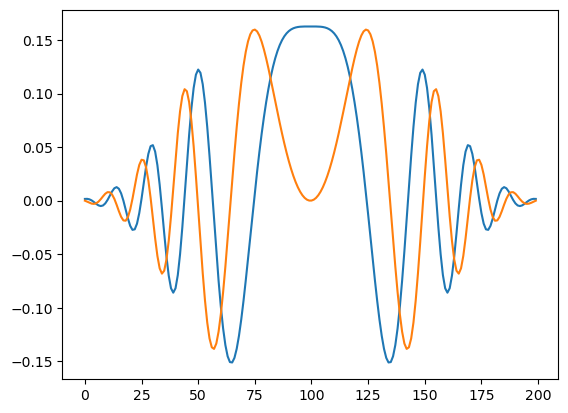

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def supergaussian(length, order, cutoff):
   """
    Generate a super-Gaussian envelope.

    Parameters:
    - length (int): Number of points in the waveform.
    - order (int): The order of the super-Gaussian (controls the sharpness).
    - cutoff (float): The cutoff value for the super-Gaussian envelope.

    Returns:
    - numpy array: The super-Gaussian envelope.
    """
   x = np.linspace(-1, 1, length)
   return np.exp(x ** order * np.log(cutoff))

def robust_wf(amp,length,mod=40e6,order=4,cutoff=1e-2):
    """
    Generate a robust waveform with phase modulation.

    Parameters:
    - amp (float): Amplitude of the pulse.
    - length (int): Number of points in the waveform.
    - mod (float): Modulation frequency in Hz (default 40 MHz).
    - order (int): Order of the super-Gaussian envelope.
    - cutoff (float): Cutoff value for the super-Gaussian envelope.

    Returns:
    - numpy array: The complex waveform with phase modulation applied.
    """
    robust_time = np.linspace(-length / 2, length / 2, length) * 1e-9
    robust_freq = np.linspace(-1, 1, length) * mod
    robust_envelope = supergaussian(length, order, cutoff)
    robust_rescaling = length / robust_envelope.sum()
    return  robust_amp * robust_rescaling * robust_envelope * np.exp(1j * 2 * np.pi * robust_time * robust_freq)

# Parameters for the robust waveform
robust_len=200
robust_amp=0.1

# Select the type of pulse to generate using the match-case structure
pulse_flag = 2 # 0 for rectangular, 1 for super-Gaussian, 2 for robust pulse

# Generate the pulse based on the selected flag

match pulse_flag:
    case 0:
        pulse = robust_wf(robust_amp,robust_len,mod=0,order=4,cutoff=1)  # rectangular pulse
    case 1:
        pulse = robust_wf(robust_amp,robust_len,mod=0,order=4,cutoff=1e-2) # super-Gaussian pulse
    case 2:
        pulse = robust_wf(robust_amp,robust_len,mod=40e6,order=4,cutoff=1e-2) # robust pulse

# Update the pulse waveforms in the co: I = real(pulse)   and Q=imag(pulse)!!! 
config['elements']['qubit']['operations'].update({'pulse':'robust_pulse'})
config['pulses'].update({"robust_pulse": {"operation": "control","length": robust_len,"waveforms": {"I":"I_wf","Q":"Q_wf",},}})
config['waveforms'].update({"I_wf": {"type": "arbitrary", "samples": np.real(pulse).tolist()}})
config['waveforms'].update({"Q_wf": {"type": "arbitrary", "samples": np.imag(pulse).tolist()}})

# Plot the real and imaginary parts of the generated pulse
plt.plot(np.real(pulse))
plt.plot(np.imag(pulse))


In [ ]:
#### QUA Program #####


# Define parameters for frequency detuning and amplitude sweeps
n_detuning = 321  # Number of detuning points
detuning_span = 160e6  # Total span of detuning in Hz
detuning_array = np.linspace(-detuning_span / 2, detuning_span / 2, n_detuning).astype(int)  # Array of detuning values centered around zero

n_a = 101  # Number of amplitude points
a_array = np.linspace(0, 2 - 2 ** -16, n_a)  # Array of amplitude values ranging from 0 to just below 2

# Define the QUA program for a Rabi amplitude and frequency sweep experiment
with program() as rabi_amp_freq:
    n = declare(int)  # Declare an integer variable for loop iteration
    f = declare(int)  # Declare an integer variable for frequency detuning
    a = declare(fixed)  # Declare a fixed-point variable for amplitude
    I = declare(fixed)  # Declare a fixed-point variable for the I (in-phase) component of the signal
    Q = declare(fixed)  # Declare a fixed-point variable for the Q (quadrature) component of the signal

    I_st = declare_stream()  # Declare a stream to store I component data
    Q_st = declare_stream()  # Declare a stream to store Q component data

    # Outer loop over the number of averages
    with for_(n, 0, n < n_avg, n + 1):
        # Loop over each amplitude value
        with for_each_(a, a_array.tolist()):
            # Loop over each detuning value
            with for_each_(detuning, detuning_array.tolist()): 
                
                # Update the qubit frequency with the current detuning value
                update_frequency('qubit', detuning + qubit_IF)
                
                # Play the pulse with the current amplitude on the qubit
                play('pulse' * amp(a), 'qubit')

                # Align the qubit and resonator operations
                align('qubit', 'resonator')

                # Perform dual demodulation measurement on the qubit signal
                measure_dual_demod()
                
                # Save the I and Q measurement results to their respective streams
                save(I, I_st)
                save(Q, Q_st)

    # Stream processing block to buffer and average the measurement results
    with stream_processing():
        I_st.buffer(n_a, n_detuning).average().save('I')  # Buffer and average I data, then save
        Q_st.buffer(n_a, n_detuning).average().save('Q')  # Buffer and average Q data, then save